# Assignment 3
## Question 1: Siamese networks & one-shot learning (8pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much less examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [1]:
# === add code here ===
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.losses import binary_crossentropy
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

c:\users\illia\appdata\local\conda\conda\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
#check gpu is working
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [80]:
from keras.datasets import cifar100

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [81]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("")


y_train

X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)



array([[19],
       [29],
       [ 0],
       ...,
       [ 3],
       [ 7],
       [73]])

In [82]:
#sort label, get the indices
sort_p=np.argsort(y_train.flatten(),axis=None)

In [83]:
#rearrange training data based on sort
x_train_new=[x_train[sort_p[i]].flatten() for i in range(50000)]
y_train_new=[y_train[sort_p[i]].flatten() for i in range(50000)]

In [84]:
#reshape train data
x_train_new2=np.reshape(x_train_new,(100, 500, 32, 32, 3))
y_train_new2=np.reshape(y_train_new,(100, 500, 1))

In [85]:
#take first 80 class as trining and last 20 as testing dataset
x_train_final=x_train_new2[0:80]
y_train_final=y_train_new2[0:80]
x_test_final=x_train_new2[80:]
y_test_final=y_train_new2[80:]

In [86]:

c_train={a:a for a in range(80)}
c_test={a:a for a in range(80,100)}

print("X_train shape:", x_train_final.shape)
#print("")
#print("training alphabets")
#print([key for key in c_train.keys()])

#c_test

X_train shape: (80, 500, 32, 32, 3)


In [8]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, d = X.shape
    #n_examples, w, h, d = X.shape
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,), replace=False)
    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, d)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(0, n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, d)
        idx_2 = np.random.randint(0, n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, d)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train(model, X_train, batch_size=32, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, X_train), steps_per_epoch=steps_per_epoch, epochs=epochs)

In [11]:
input_shape = (32, 32, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

# build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64, (5,5), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(128, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Conv2D(256, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
convnet.add(Flatten())
convnet.add(BatchNormalization())
convnet.add(Dropout(0.25))
convnet.add(Dense(4096, activation="sigmoid", kernel_regularizer=l2(1e-3)))
convnet.summary()

# encode each of the two inputs into a vector with the convnet
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

# merge two encoded inputs with the L1 distance between them, and connect to prediction output layer
L1_distance = lambda x: K.abs(x[0]-x[1])
both = Lambda(L1_distance)([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid')(both)
siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)


siamese_net.compile(loss="binary_crossentropy", optimizer="adam")

siamese_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 128)         512       
__________

In [9]:
def make_oneshot_task(N, X, c, language=None):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, d = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    #if language is not None:
        #low, high = c[language]
        #if N > high - low:
        #    raise ValueError("This language ({}) has less than {} letters".format(language, N))
    #    categories = np.random.choice(range(low,high), size=(N,), replace=False)
    #else:  # if no language specified just pick a bunch of random letters
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)    
    #print(categories)
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, d)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, d)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, c, N=20, k=250, language=None, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X, c, language=language)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [10]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [11]:
pairs, targets = make_oneshot_task(20, x_train_final, c_train, language=5)

In [77]:
import h5py

In [29]:
loops = 250
best_acc = 0
for i in range(loops):
    print("=== Training loop {} ===".format(i+1))
    train(siamese_net, x_train_final)
    test_acc = test_oneshot(siamese_net, x_test_final, c_test)
    if test_acc >= best_acc:
        print("New best one-shot accuracy, saving model ...")
        siamese_net.save(os.path.join("models", "siamese_omniglot.h5"))
        best_acc = test_acc

=== Training loop 1 ===
Epoch 1/1
100/100 [==============================] - 4s 36ms/step - loss: 0.6819
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 2 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6797
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 3 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6899
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
New best one-shot accuracy, saving model ...
=== Training loop 4 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6803
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-

100/100 [==============================] - 3s 33ms/step - loss: 0.6715
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 71 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6658
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.2% accuracy for 20-way one-shot learning
=== Training loop 72 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6769
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 73 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6838
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 74 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 

100/100 [==============================] - 3s 33ms/step - loss: 0.6756
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20-way one-shot learning
=== Training loop 106 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6858
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
=== Training loop 107 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6732
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 8.0% accuracy for 20-way one-shot learning
=== Training loop 108 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6656
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 20-way one-shot learning
=== Training loop 109 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - los

100/100 [==============================] - 3s 33ms/step - loss: 0.6758
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.8% accuracy for 20-way one-shot learning
=== Training loop 141 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6784
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20-way one-shot learning
=== Training loop 142 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6665
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 9.6% accuracy for 20-way one-shot learning
=== Training loop 143 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6681
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.6% accuracy for 20-way one-shot learning
=== Training loop 144 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - los

100/100 [==============================] - 3s 33ms/step - loss: 0.6650
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20-way one-shot learning
=== Training loop 176 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6807
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 177 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6729
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 178 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6716
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.6% accuracy for 20-way one-shot learning
=== Training loop 179 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - lo

100/100 [==============================] - 3s 33ms/step - loss: 0.6667
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.0% accuracy for 20-way one-shot learning
=== Training loop 211 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6640
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 212 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6604
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 12.4% accuracy for 20-way one-shot learning
=== Training loop 213 ===
Epoch 1/1
100/100 [==============================] - 3s 33ms/step - loss: 0.6701
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.8% accuracy for 20-way one-shot learning
=== Training loop 214 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - lo

100/100 [==============================] - 3s 34ms/step - loss: 0.6685
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.2% accuracy for 20-way one-shot learning
=== Training loop 246 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6655
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 17.6% accuracy for 20-way one-shot learning
=== Training loop 247 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6694
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
=== Training loop 248 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - loss: 0.6689
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.4% accuracy for 20-way one-shot learning
=== Training loop 249 ===
Epoch 1/1
100/100 [==============================] - 3s 34ms/step - lo

In [30]:
print('Best acc: ',best_acc)

Best acc:  22.4


***

**b)** Briefly motivate your model's architecture, as well as its performance. What accuracy would random guessing achieve (on average)?

**Answer:**

The task at hand has some overlap with the omniglot task. Therefore the architecture used there seemed like a good starting point.
However there are some differences in the task at hand. One obvious difference is the dimensionality of the data.
Omniglot uses inputs of (105,105,3), the cifar-100 set has images of (32,32,3). Thus leaving the original omniglot kernel size in place on the convolutional layers would not work.
The image would fast be reduced to such a small size it would be hard to capture any features. Thus the kernel size has been adapted for the task at hand.
The performance one would expect on random guessing is 1/20 for every image. so a 5% accuracy is expected.
The performance of the network at a max of 22.4% is vastly superior to the random guess.

***

**c)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

The differences between the datasets are based within the classes. 
Omniglot has 50 superclasses which are the alphabets, cifar has 20 super classes although these are not used here.
The omniglot superclasses however are used they are the end result. The alphabet classes have 20 subclasses of letters.
In the superclasses of cifar we find 5 subclasses thus there are less subclasses to link to a superclass. 
The difference in task is that in the omniglot challenge the subclass is not required we just need to estimate the superclass.
In the cifar 1 shot task the subclass needs to be correct which leaves more possibilities open. This in turn results in a harder task
and an expected lower accuracy.

Then there is the bandwith within the subclasses. A picture of a bus can be vastly different from another picture of a bus.
In the omniglot dataset the characters have a tighter bandwith. The character a will have some differences due to handwriting and positioning.
But it will never have the same bandwith as images of busses. this results in the cifar task being exponentially harder than the omniglot task.

Before the bandwith within the subclasses was discussed, but there is another fundamental difference between subclasses. In the omniglot dataset
we have characters which are designed to be visually different. an A shares very little features with a character B. In the cifar dataset we have
subclasses like hamster,mouse,rabbit,squirrel. These animals will share features and are harder to distinguish from each other.
Again the cifar task proofs to be harder than the omniglot task.


***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [5]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K

# load the data
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

# properties of the data
img_rows, img_cols, chns = 32, 32, 3
n_classes = 100

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

#classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]



X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 100)


In [6]:
# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 80).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 80).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 80).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 80).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :80]
y_train_r = y_train_r[:, 80:]
y_test_l = y_test_l[:, :80]
y_test_r = y_test_r[:, 80:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

(80000, 32, 32, 3)
(20000, 32, 32, 3)
(80000, 80)
(20000, 20)
(80000, 1)
(20000, 1)
(16000, 32, 32, 3)
(4000, 32, 32, 3)
(16000, 80)
(4000, 20)
(16000, 1)
(4000, 1)


In [11]:
input_shape = input_shape = (32, 32, 3)

cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape,name="neural_codes_cnn_1"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu',name="neural_codes_cnn_2"))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Flatten())
cnn.add(Dense(128, name="neural_codes_cnn_3"))
cnn.add(Dense(80, activation='softmax',name="neural_codes_cnn_4"))
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
neural_codes_cnn_1 (Conv2D)  (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
neural_codes_cnn_2 (Conv2D)  (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 14, 14, 64)        0         
__________

In [12]:
batch_size = 100
epochs = 20
cnn.fit(x_train_l, y_train_l,batch_size=batch_size,epochs=epochs,validation_split=0.1)

Train on 72000 samples, validate on 8000 samples
Epoch 1/20
72000/72000 [==============================] - 34s 472us/step - loss: 2.2703 - acc: 0.5814 - val_loss: 1.7539 - val_acc: 0.5907
Epoch 2/20
72000/72000 [==============================] - 33s 460us/step - loss: 1.3931 - acc: 0.6558 - val_loss: 1.5033 - val_acc: 0.6305
Epoch 3/20
72000/72000 [==============================] - 33s 461us/step - loss: 1.2199 - acc: 0.6895 - val_loss: 1.3645 - val_acc: 0.6573
Epoch 4/20
72000/72000 [==============================] - 33s 460us/step - loss: 1.1133 - acc: 0.7112 - val_loss: 1.4185 - val_acc: 0.6477
Epoch 5/20
72000/72000 [==============================] - 33s 460us/step - loss: 1.0334 - acc: 0.7282 - val_loss: 1.3114 - val_acc: 0.6683
Epoch 6/20
72000/72000 [==============================] - 33s 461us/step - loss: 0.9618 - acc: 0.7434 - val_loss: 1.2574 - val_acc: 0.6811
Epoch 7/20
72000/72000 [==============================] - 33s 461us/step - loss: 0.8974 - acc: 0.7581 - val_loss: 1.3

In [24]:
loss, accuracy = cnn.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 2.0107322149276734
Test accuracy: 0.6729375


In [41]:
# save the model
cnn.save(os.path.join("models", "cnn.h5"))

In [19]:
# load the previously trained and saved models
cnn = load_model(os.path.join("models", "cnn.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes_cnn_3").output)


# obtain 128-dimensional representations
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)

# print the shapes to confirm all features are 128-dimensional
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)


(20000, 128)
(4000, 128)


In [20]:
from sklearn.neighbors import NearestNeighbors
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [21]:
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [54]:
print(x_train_r.shape)

(20000, 32, 32, 3)


Test Image number 1:


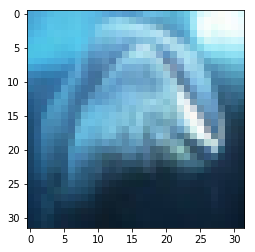

class= 15
Retrieved Image:


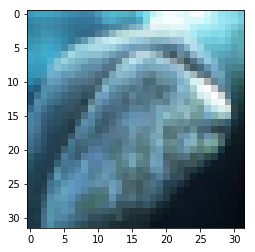

class= 15
Test Image number 2:


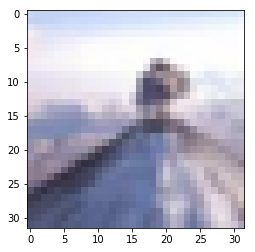

class= 0
Retrieved Image:


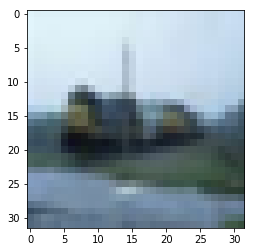

class= 10
Test Image number 3:


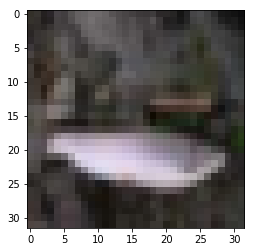

class= 11
Retrieved Image:


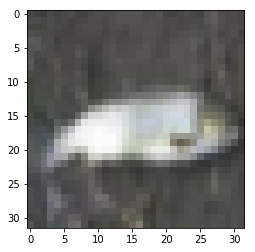

class= 11
Test Image number 4:


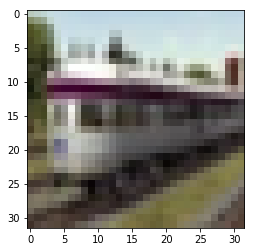

class= 10
Retrieved Image:


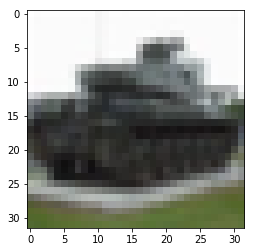

class= 5
Test Image number 5:


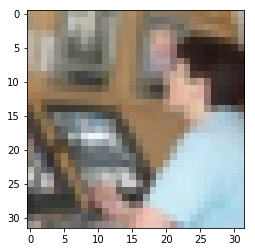

class= 7
Retrieved Image:


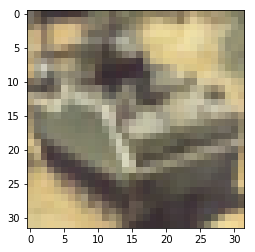

class= 5
Test Image number 6:


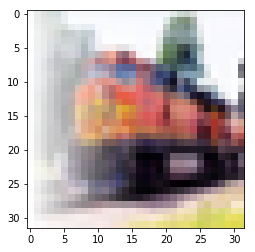

class= 10
Retrieved Image:


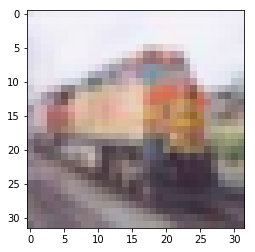

class= 10
Test Image number 7:


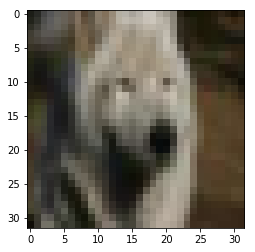

class= 17
Retrieved Image:


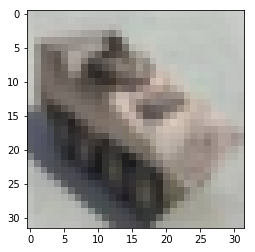

class= 5
Test Image number 8:


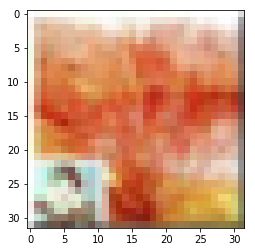

class= 16
Retrieved Image:


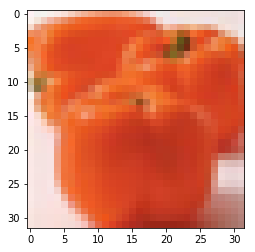

class= 3
Test Image number 9:


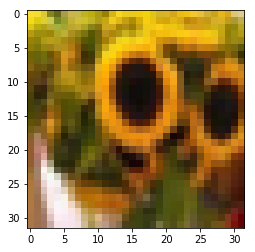

class= 2
Retrieved Image:


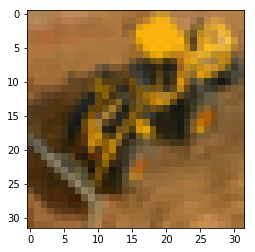

class= 9
Test Image number 10:


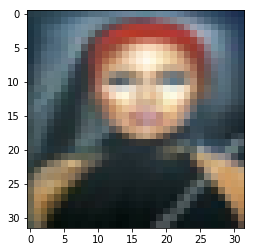

class= 18
Retrieved Image:


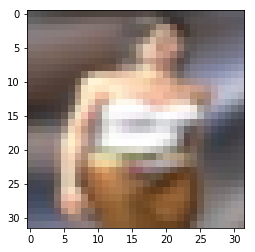

class= 18
Test Image number 11:


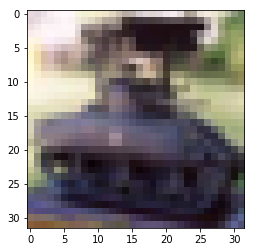

class= 5
Retrieved Image:


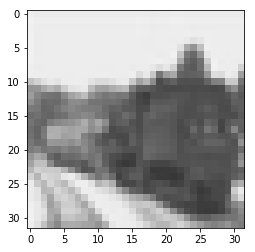

class= 1
Test Image number 12:


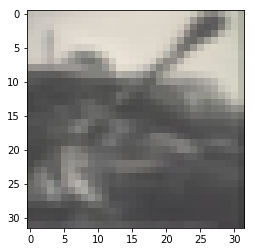

class= 5
Retrieved Image:


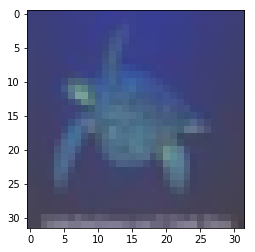

class= 13
Test Image number 13:


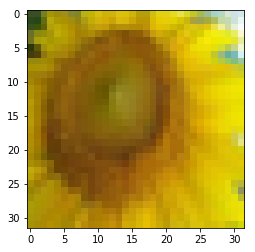

class= 2
Retrieved Image:


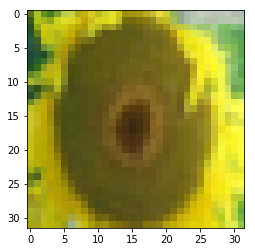

class= 2
Test Image number 14:


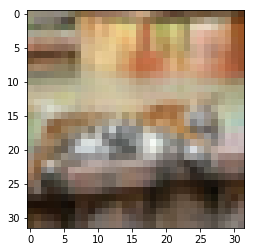

class= 8
Retrieved Image:


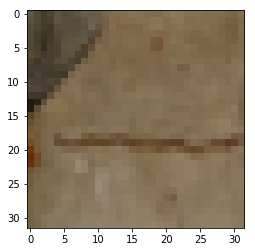

class= 19
Test Image number 15:


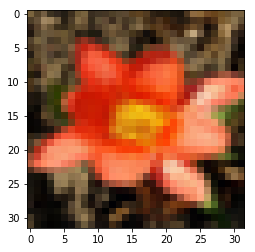

class= 12
Retrieved Image:


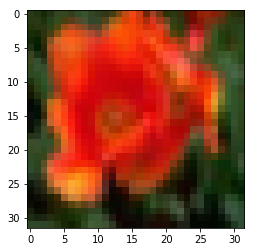

class= 12
Test Image number 16:


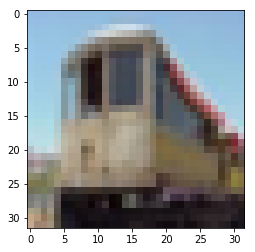

class= 1
Retrieved Image:


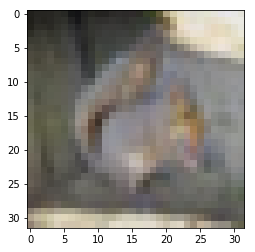

class= 0
Test Image number 17:


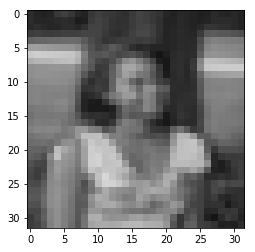

class= 18
Retrieved Image:


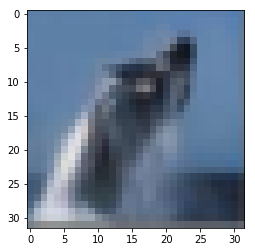

class= 15
Test Image number 18:


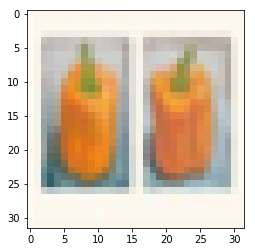

class= 3
Retrieved Image:


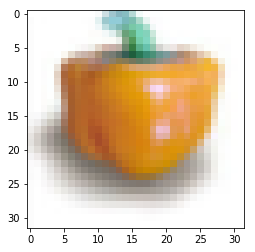

class= 3
Test Image number 19:


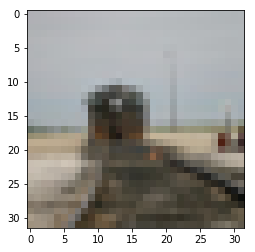

class= 10
Retrieved Image:


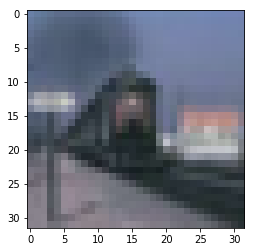

class= 10
Test Image number 20:


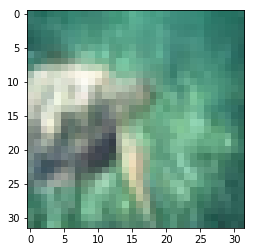

class= 13
Retrieved Image:


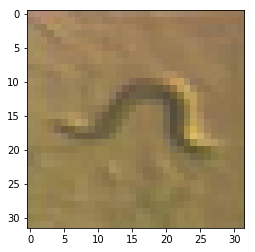

class= 19
Test Image number 21:


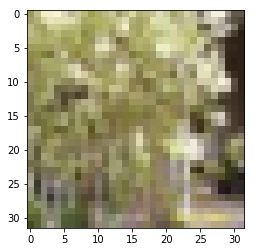

class= 16
Retrieved Image:


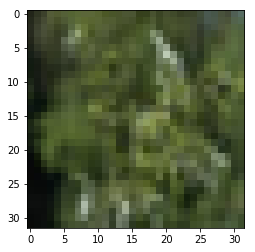

class= 16
Test Image number 22:


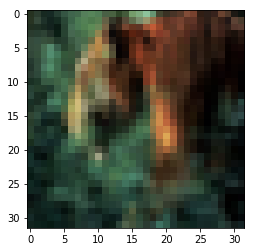

class= 8
Retrieved Image:


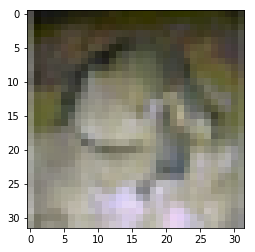

class= 13
Test Image number 23:


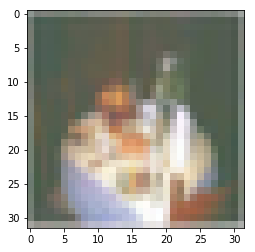

class= 4
Retrieved Image:


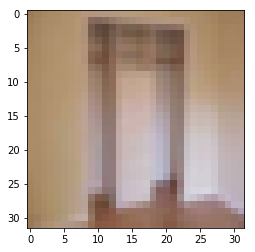

class= 14
Test Image number 24:


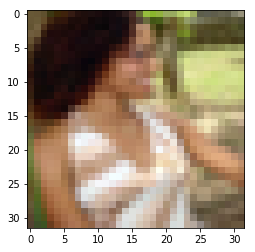

class= 18
Retrieved Image:


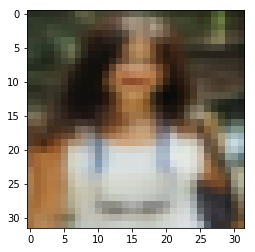

class= 18
Test Image number 25:


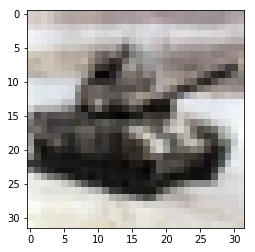

class= 5
Retrieved Image:


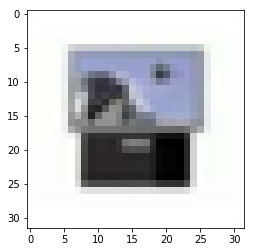

class= 7
Test Image number 26:


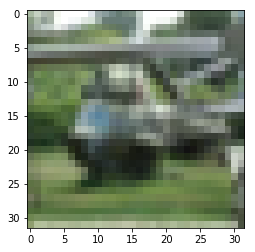

class= 5
Retrieved Image:


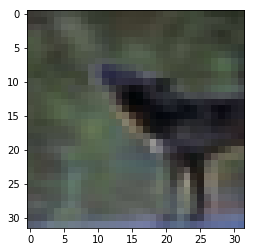

class= 17
Test Image number 27:


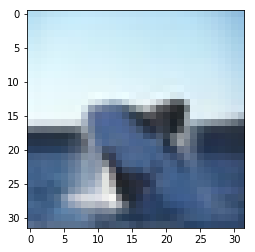

class= 15
Retrieved Image:


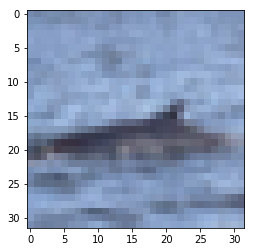

class= 15
Test Image number 28:


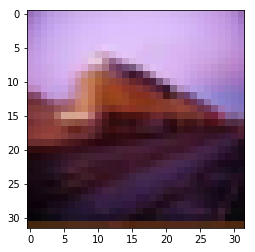

class= 10
Retrieved Image:


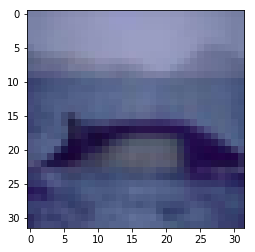

class= 15
Test Image number 29:


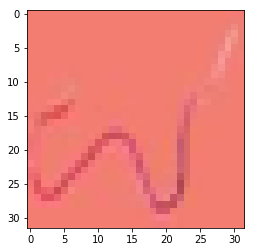

class= 19
Retrieved Image:


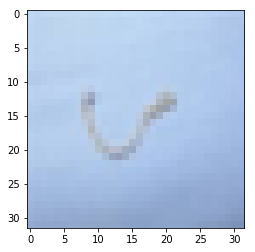

class= 19
Test Image number 30:


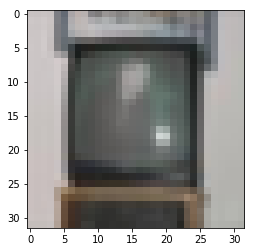

class= 7
Retrieved Image:


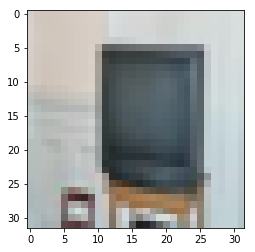

class= 7
Test Image number 31:


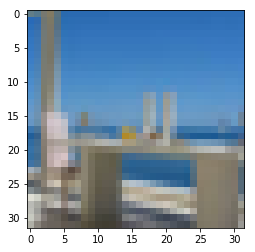

class= 4
Retrieved Image:


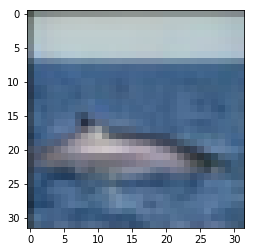

class= 15
Test Image number 32:


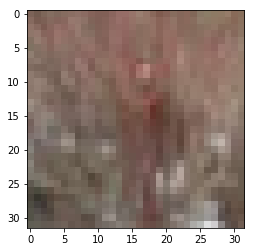

class= 16
Retrieved Image:


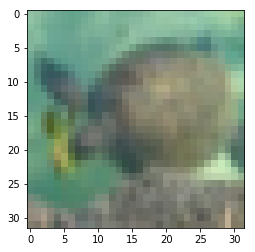

class= 13
Test Image number 33:


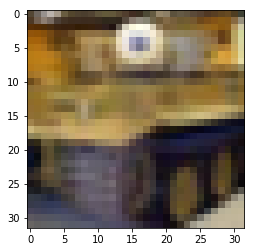

class= 5
Retrieved Image:


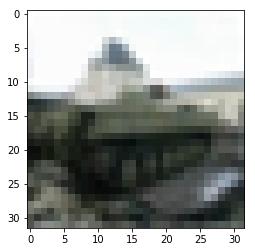

class= 5
Test Image number 34:


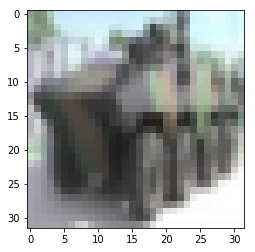

class= 5
Retrieved Image:


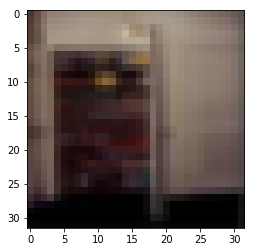

class= 14
Test Image number 35:


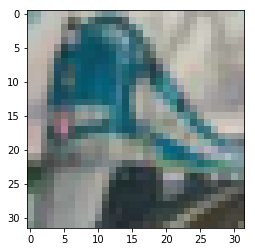

class= 10
Retrieved Image:


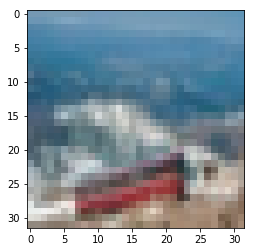

class= 10
Test Image number 36:


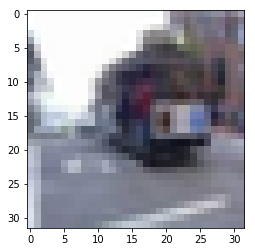

class= 1
Retrieved Image:


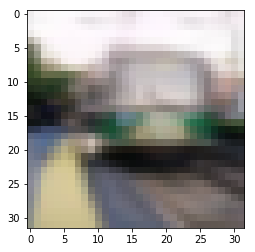

class= 1
Test Image number 37:


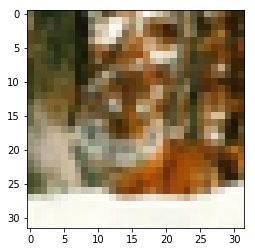

class= 8
Retrieved Image:


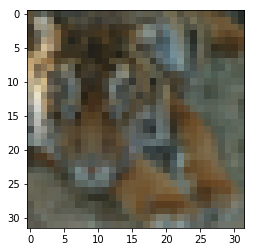

class= 8
Test Image number 38:


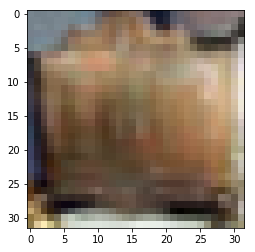

class= 14
Retrieved Image:


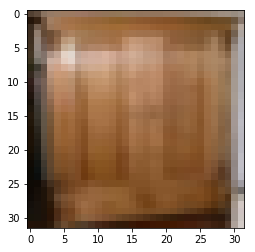

class= 14
Test Image number 39:


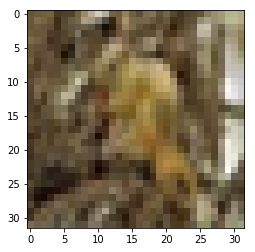

class= 0
Retrieved Image:


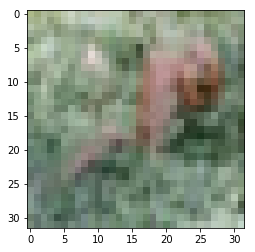

class= 0
Test Image number 40:


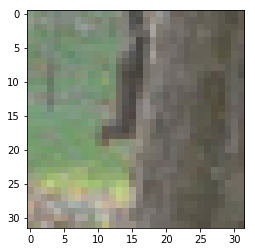

class= 0
Retrieved Image:


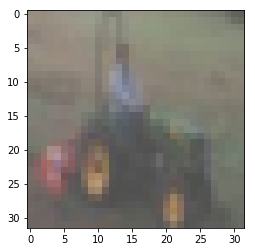

class= 9
Test Image number 41:


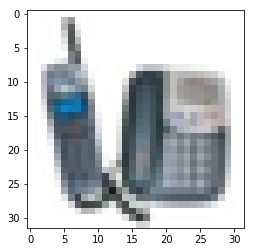

class= 6
Retrieved Image:


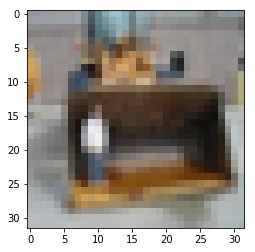

class= 9
Test Image number 42:


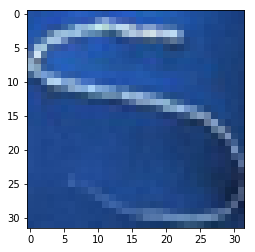

class= 19
Retrieved Image:


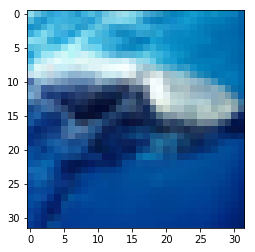

class= 15
Test Image number 43:


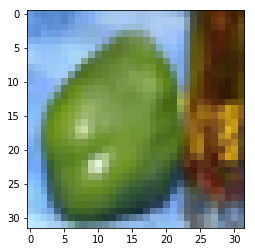

class= 3
Retrieved Image:


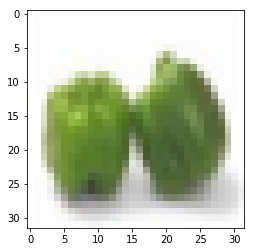

class= 3


In [87]:
# make random selection of n query images/indices, the same for all experiments
def uniq(x):
    return len(x) == len(set(x))

n = 100
n_examples = 4000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)
result={}
shown=set()

representations = [
    (nc_cnn_train, nc_cnn_test),
]

it=0
idt=['cnn']
for (nc_train, nc_test) in representations:

    #nsamples, nx, ny = nc_test.shape
    # === SOLUTION: ===
    neigh = NearestNeighbors(n_neighbors=1, p=2)
    #nc_test_rs=nc_test.reshape((n_examples,nx*ny))
    neigh.fit(nc_train)
    X_fc = nc_test[indices]
    
    nn = neigh.kneighbors(X_fc)
    cnt=1
    for i in range(len(nn[0])):
        if(uniq(nn[1][i]) and not nn[1][i][0] in shown):
            print("========================================================")
            print("Test Image number {}:".format(cnt))
            plt.imshow(x_test_r[indices[i]])
            plt.show()
            print('class=',np.argmax(y_test_r[indices[i]]))
            print("Retrieved Image:")    
            #print("Index list:",nn[1][i])
            for j in range(1):
                plt.imshow(x_train_r[(nn[1][i][j])])
                plt.show()
                print('class=',np.argmax(y_train_r[(nn[1][i][j])]))
                shown.add(nn[1][i][j])
            cnt+=1
        #if(cnt%3==0 and cnt>0):
            
        #if(cnt==30):
        #    break

***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

he cnn architecture is based on the same convolutions as the siamese network. With the difference being that the final layer in the cnn has 80 neurons.
Resulting in a signal for each class. The siamese network has a final dense layer of 4096 neurons. 
The cnn has a dense layer before the final layer of 128. Thus the feature space in which the siamese net is vastly greater than the cnn. The siamese net will therefore
be able to store more features in the resulting vector than the cnn and be able to come to better conclusions.
The cnn is updated by the backpropegation algorithm for classification thus it will try to extract features and give signals to one of the 80 classes.
The siamese net is more designed by the mergelayer through which the update goes to detect features and differences between them.Therefore the networks
will focus on different features and make different choices on how to optimize the weights for their task.
The siamese net is really designed to work towards a yes no desicion whilst the cnn has to choose from 80 classes. The siamese net can thus focus on 
differences in features whilst the cnn focusses on combining features and coming to a conclusion.

